## Knowledge distillation 과정

In [1]:
from new_model import *

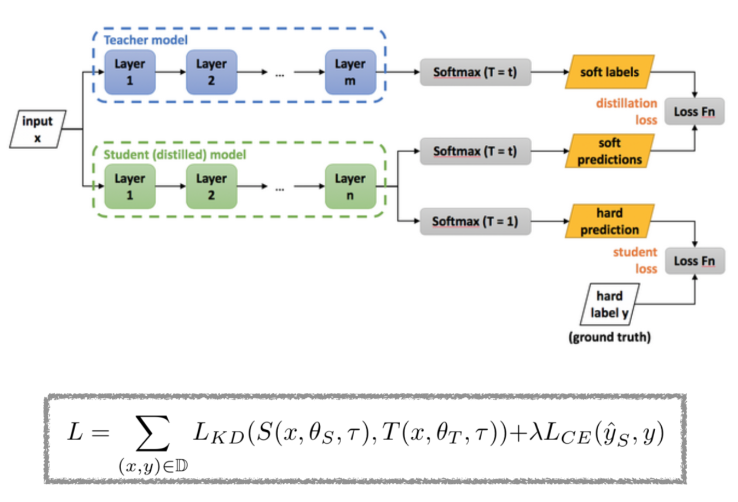

L은 손실함수, S는 stduent model, T는 teacher model, (x,y)는 이미지 1개와 , 그 이미지의 label, theta는 모델의 학습 파라미터, tau는 temperature

위 손실함수는 Cross Entropy Loss(L_ce)와 Distillation Loss(L_kd)로 구성된다. 

L_CE : Original (hard) label과 student network hard prediction을 이용하여 CrossEntropy loss 구성한다.(기존)

L_KD : 학습된 teacher model의 soft labels와 student model의 soft predictions를 비교하여 Knowledge Distillation loss 를 구성한다(신규)

온도(tau)는 동일하게 설정하고 Cross entropy loss를 사용

In [2]:
seed = 10
random.seed(seed)
np.random.seed(seed)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(seed)
if device == 'cuda':
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## 1. Studen_loss에 대한 정의

In [3]:
def studentLoss(teacher_pred, student_pred, targets, T, alpha):
    """
    Loss function for student network: Loss = alpha * (distillation loss with soft-target) + (1 - alpha) * (cross-entropy loss with true label)
    Return: loss
    soft target 은 Teacher model의 지식이다. 학습방법은 큰 모델(T)을 학습 시킨후 작은 모델(S)을 손실함수를 통해 학습한다
    """
    if alpha > 0:
        loss = F.kl_div((F.softmax(student_pred/T, dim=1) + 1e-12).log(), F.softmax(teacher_pred.detach()/T, dim=1) + 1e-12, reduction='batchmean')* (T**2) * alpha + F.cross_entropy(student_pred, targets) * (1 - alpha)
        #KL divergence Loss가 reduction이 mean이 default 값인데, 이러면 진짜 KL divergence Loss를 안뱉는다고 한다.
    else:
        loss = F.cross_entropy(student_pred, targets)

    return loss

## 2. distillation 모델 : train, test 정의

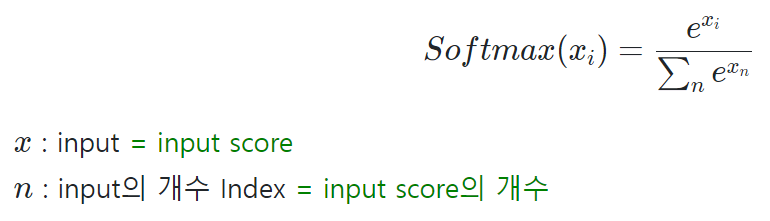

    '''
    nn.Softmax(dim=None) :
    - n차원 input tensor에 대해 softmax function을 적용시키고, output tensor는 input tensor와 같은 shape에 모든 값들을 0~1 사이 값이며, 
        (dim)에 따라 sum 값이 1이 된다. (dim=1이면 1차원에서의 합이 1이 되는 것)
    - 왜 하냐? 계산하고자 하는 output classification의 개수. 즉, class 개수가 여러개 일때 사용하는 것이 softmax function이다
    - 위 그림에서 x는 input score(확률값)이고 n은 input score의 개수이다.즉 score 1개에 대해서 어느 클래스인지 확률이 나오는데 
        이때 그 값이 0~1이어야 하고 합은 1이어야 한다.(클래스일 확률이 가장 높은게 정답이겠지?)
    '''

In [4]:
#여기서 model은 student_model을 말한다.
def distillationTraining(student, teacher, mode):
    
    EPOCHS = 200
    print(f'Now T is {T}')

    # the folder where the trained model is saved , 여기 server에 saved_model이라는 파일은 만들어서 trained model을 저장시키겠다
    CHECKPOINT_PATH = "./save_seed10_CIFAR100"
    
    best_val_acc = 0
    current_learning_rate = INITIAL_LR
    softmax = torch.nn.Softmax(dim=1)     
    
    print("==> Start training!")
    
    ## 학습 시작
    start = time.time() 
    optimizer = torch.optim.SGD(student.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [60, 120, 160], gamma = 0.2)
    for i in range(0, EPOCHS):
        
        student.train() #teacher의 경우 학습하지 않는다
        
        total_examples = 0
        correct_examples = 0
        train_loss = 0
        
        '''
        train loop
        '''
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            student_pred = student(inputs)
            if alpha > 0:
                with torch.no_grad():
                    teacher_pred = teacher(inputs)
            else:
                teacher_pred = 0
            train_loss = studentLoss(teacher_pred, student_pred, targets, T, alpha)
            
            optimizer.zero_grad()
            
            train_loss.backward()
            
            optimizer.step()
            
            total_examples += inputs.shape[0]

            out = softmax(student_pred)
            out = torch.max(out, 1)

            correct_examples += torch.sum(targets==out[1]).cpu().data.numpy().tolist()
        
        scheduler.step()    
        avg_loss_tr = train_loss / len(train_loader)
        avg_acc_tr = correct_examples / total_examples
        
        
        '''
        validation loop
        '''
        
        student.eval()

        total_examples = 0
        correct_examples = 0
        
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(val_loader):
                inputs, targets = inputs.to(device), targets.to(device)
                student_pred = student(inputs)
                val_loss = criterion(student_pred, targets)
                total_examples += inputs.shape[0]
                out = softmax(student_pred)
                out = torch.max(out, 1)
                correct_examples += torch.sum(targets==out[1]).cpu().data.numpy().tolist()
                
        avg_loss_val = val_loss / len(val_loader)
        avg_acc_val = correct_examples / total_examples

        if avg_acc_val > best_val_acc:
            best_val_acc = avg_acc_val
            if not os.path.exists(CHECKPOINT_PATH):
                os.makedirs(CHECKPOINT_PATH)            
            state = {'state_dict': student.state_dict(),
                      'epoch': i,
                      'lr': current_learning_rate}
            
            torch.save(state, os.path.join(CHECKPOINT_PATH, '{}.pth'.format(mode)))        
    
        
        if i % 10 == 9 : 
            end = time.time()
            diff_time = round(end - start,2)
            print("Epoch %d:" %(i+1), f"progress time is {diff_time} sec")
            print("Training loss: {}, training accuracy: {}".format(avg_loss_tr, avg_acc_tr))
            print("Val loss: {}, val accuracy: {}".format(avg_loss_val, avg_acc_val))
    return student 

In [5]:
def test_model(model):
    model.to(device)
    model.eval()

    total_examples = 0
    correct_examples = 0
    softmax = torch.nn.Softmax(dim=1)

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            pred = model(inputs)
            total_examples += inputs.shape[0]

            out = softmax(pred)
            out = torch.max(out, 1)

            correct_examples += torch.sum(targets==out[1]).cpu().data.numpy().tolist()

    avg_acc = correct_examples / total_examples
    print("Total examples is {}, correct examples is {}; Test accuracy: {}".format(total_examples, correct_examples, avg_acc))

## Setup Training

In [6]:
#Data 다운로드 경로지정
batch_size = 128


#Data Process 
transform_train = transforms.Compose([transforms.RandomCrop(32, padding=4),transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]) 

transform_val = transforms.Compose([transforms.ToTensor(), 
                                    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010))])

transform_test = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010))])

train_CIFAR10 = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform_train)

test_CIFAR10 = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform_test)

num_train = int(1.0 * len(train_CIFAR10) * 95 / 100)
num_val = len(train_CIFAR10) - num_train
train_CIFAR10, val_CIFAR10 = torch.utils.data.random_split(train_CIFAR10, [num_train, num_val])

train_loader = torch.utils.data.DataLoader(train_CIFAR10, batch_size=batch_size, shuffle=True, num_workers=2) #num_workers는 데이터 로드시 sub process 몇개 쓸거냐 
val_loader = torch.utils.data.DataLoader(val_CIFAR10, batch_size=batch_size,shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_CIFAR10, batch_size=batch_size, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
#Data 다운로드 경로지정
batch_size = 128

#Data Process
transform_train = transforms.Compose([transforms.RandomCrop(32, padding=4),transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]) 

transform_val = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]) 

transform_test = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]) 

train_CIFAR100 = torchvision.datasets.CIFAR100(root='../data', train=True, download=True, transform=transform_train)

test_CIFAR100 = torchvision.datasets.CIFAR100(root='../data', train=False, download=True, transform=transform_test)

num_train = int(1.0 * len(train_CIFAR100) * 95 / 100)
num_val = len(train_CIFAR100) - num_train
train_CIFAR100, val_CIFAR100 = torch.utils.data.random_split(train_CIFAR100, [num_train, num_val])

train_loader = torch.utils.data.DataLoader(train_CIFAR100, batch_size=batch_size, shuffle=True, num_workers=2) #num_workers는 데이터 로드시 sub process 몇개 쓸거냐 
val_loader = torch.utils.data.DataLoader(val_CIFAR100, batch_size=batch_size,shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_CIFAR100, batch_size=batch_size, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
INITIAL_LR = 0.1

REG = 5e-4

MOMENTUM = 0.9

criterion = nn.CrossEntropyLoss()

# Temperature(T)를 지정해주는 것이 핵심
T = 10
alpha = 0.9

## teacher model과 student model이 sparstiy modeling의 wide_resnet을 기반으로 하기에 파일 경로를 바꿔준다

In [8]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [9]:
# Teacher Model : WideResnet10을 Teacher로 WideResnet2를 Student로 세워본다
teacher = Wide_ResNet(28, 10, 0.3, 100).to(device)
checkpoint = torch.load("../1.Wide_ResNet_model/saved_model/WR_28x10_cifar100.pth")
teacher.load_state_dict(checkpoint['state_dict']) 

# Student Model
student = Wide_ResNet(28, 4, 0.3, 100).to(device)

| Wide-Resnet 28x10
| Wide-Resnet 28x4


In [14]:
distillationTraining(student, teacher, 'distillation_10to4_cifar10_T=20')

Now T is 20
==> Start training!
Epoch 10: progress time is 1360.26 sec
Training loss: 0.0038158970419317484, training accuracy: 0.8558947368421053
Val loss: 0.07886108011007309, val accuracy: 0.8088
Epoch 20: progress time is 2733.29 sec
Training loss: 0.002848986769095063, training accuracy: 0.8874526315789474
Val loss: 0.027340847998857498, val accuracy: 0.8564
Epoch 30: progress time is 4106.98 sec
Training loss: 0.0037908582016825676, training accuracy: 0.8993684210526316
Val loss: 0.018494047224521637, val accuracy: 0.8692
Epoch 40: progress time is 5472.24 sec
Training loss: 0.0009302737889811397, training accuracy: 0.910821052631579
Val loss: 0.02848406508564949, val accuracy: 0.8172
Epoch 50: progress time is 6843.93 sec
Training loss: 0.001775685464963317, training accuracy: 0.9144842105263158
Val loss: 0.031053287908434868, val accuracy: 0.8424
Epoch 60: progress time is 8216.14 sec
Training loss: 0.005470333620905876, training accuracy: 0.9138736842105263
Val loss: 0.0085933

Wide_ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (M_relu): M_relu()
  (layer1): Sequential(
    (0): M_BasicBlock(
      (conv1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (M_relu1): M_relu()
      (dropout): Dropout(p=0.3, inplace=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (M_relu2): M_relu()
      (shortcut): Sequential(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): M_BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3)

In [10]:
distillationTraining(student, teacher, 'KD_10to4_T=10')

Now T is 10
==> Start training!
Epoch 10: progress time is 1339.49 sec
Training loss: 0.0027079975698143244, training accuracy: 0.623578947368421
Val loss: 0.08452145010232925, val accuracy: 0.5288
Epoch 20: progress time is 2681.34 sec
Training loss: 0.0015206843381747603, training accuracy: 0.704021052631579
Val loss: 0.08541430532932281, val accuracy: 0.6044
Epoch 30: progress time is 4022.31 sec
Training loss: 0.0015196515014395118, training accuracy: 0.7281052631578947
Val loss: 0.09156116843223572, val accuracy: 0.5552
Epoch 40: progress time is 5363.05 sec
Training loss: 0.0017327765235677361, training accuracy: 0.7401473684210527
Val loss: 0.05814240127801895, val accuracy: 0.6284
Epoch 50: progress time is 6703.23 sec
Training loss: 0.0012005626922473311, training accuracy: 0.7471157894736842
Val loss: 0.09415819495916367, val accuracy: 0.6288
Epoch 60: progress time is 8042.18 sec
Training loss: 0.0010305679170414805, training accuracy: 0.7523578947368421
Val loss: 0.09836781

Wide_ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (M_relu): M_relu()
  (layer1): Sequential(
    (0): M_BasicBlock(
      (conv1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (M_relu1): M_relu()
      (dropout): Dropout(p=0.3, inplace=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (M_relu2): M_relu()
      (shortcut): Sequential(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): M_BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3)

## seed 10

In [11]:
distillationTraining(student, teacher, 'KD_10to4_T=10') ##cifar10

Now T is 10
==> Start training!
Epoch 10: progress time is 1252.58 sec
Training loss: 0.0019257799722254276, training accuracy: 0.8411578947368421
Val loss: 0.05630584433674812, val accuracy: 0.7836
Epoch 20: progress time is 2507.04 sec
Training loss: 0.0031344981398433447, training accuracy: 0.881957894736842
Val loss: 0.04153313860297203, val accuracy: 0.8064
Epoch 30: progress time is 3761.03 sec
Training loss: 0.0026665155310183764, training accuracy: 0.8991789473684211
Val loss: 0.02656661346554756, val accuracy: 0.8412
Epoch 40: progress time is 5008.96 sec
Training loss: 0.0041298698633909225, training accuracy: 0.9082736842105263
Val loss: 0.05069725587964058, val accuracy: 0.8064
Epoch 50: progress time is 6256.72 sec
Training loss: 0.006211609113961458, training accuracy: 0.9083368421052631
Val loss: 0.02236030250787735, val accuracy: 0.8228
Epoch 60: progress time is 7503.37 sec
Training loss: 0.0015021145809441805, training accuracy: 0.9116842105263158
Val loss: 0.05608638

Wide_ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (M_relu): M_relu()
  (layer1): Sequential(
    (0): M_BasicBlock(
      (conv1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (M_relu1): M_relu()
      (dropout): Dropout(p=0.3, inplace=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (M_relu2): M_relu()
      (shortcut): Sequential(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): M_BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3)

In [10]:
distillationTraining(student, teacher, 'KD_10to4_T=10') ##cifar100

Now T is 10
==> Start training!
Epoch 10: progress time is 1260.8 sec
Training loss: 0.0015810361364856362, training accuracy: 0.6236631578947368
Val loss: 0.0809384137392044, val accuracy: 0.5232
Epoch 20: progress time is 2521.85 sec
Training loss: 0.0012993385316804051, training accuracy: 0.7009263157894737
Val loss: 0.10404954105615616, val accuracy: 0.546
Epoch 30: progress time is 3779.71 sec
Training loss: 0.0013623404083773494, training accuracy: 0.7271368421052632
Val loss: 0.08923394978046417, val accuracy: 0.572
Epoch 40: progress time is 5036.54 sec
Training loss: 0.0012480203295126557, training accuracy: 0.7394315789473684
Val loss: 0.11038953065872192, val accuracy: 0.5784
Epoch 50: progress time is 6293.01 sec
Training loss: 0.0014628160279244184, training accuracy: 0.7463578947368421
Val loss: 0.09518323093652725, val accuracy: 0.5776
Epoch 60: progress time is 7547.69 sec
Training loss: 0.00148313760291785, training accuracy: 0.7557263157894737
Val loss: 0.101960919797

Wide_ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (M_relu): M_relu()
  (layer1): Sequential(
    (0): M_BasicBlock(
      (conv1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (M_relu1): M_relu()
      (dropout): Dropout(p=0.3, inplace=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (M_relu2): M_relu()
      (shortcut): Sequential(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): M_BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3)

# Test

In [16]:
# knowledge distillation으로 돌린 모델
distilled_model = Wide_ResNet(28, 4, 0.3, 10)
checkpoint = torch.load("./saved_model/distillation_10to4_cifar10_T=20.pth")
distilled_model.load_state_dict(checkpoint['state_dict'])

test_model(distilled_model)
send_email('distillation_10to2_cifar10_T=20')

| Wide-Resnet 28x4
Total examples is 10000, correct examples is 9573; Test accuracy: 0.9573


In [12]:
# CIFAR100 
# knowledge distillation으로 돌린 모델 
distilled_model = Wide_ResNet(28, 4, 0.3, 100)
checkpoint = torch.load("./saved_model_CIFAR100/KD_10to4_T=10.pth")
distilled_model.load_state_dict(checkpoint['state_dict'])

test_model(distilled_model)
# send_email('distillation_2to1_cifar10_T=4')

| Wide-Resnet 28x4
Total examples is 10000, correct examples is 7860; Test accuracy: 0.786


In [13]:
# CIFAR100 
# knowledge distillation으로 돌린 모델 
distilled_model = Wide_ResNet(28, 4, 0.3, 100)
checkpoint = torch.load("./saved_model_CIFAR100/KD_10to4_T=4.pth")
distilled_model.load_state_dict(checkpoint['state_dict'])

test_model(distilled_model)
# send_email('distillation_2to1_cifar10_T=4')

| Wide-Resnet 28x4
Total examples is 10000, correct examples is 7908; Test accuracy: 0.7908


## seed 10

In [12]:
# knowledge distillation으로 돌린 모델
distilled_model = Wide_ResNet(28, 4, 0.3, 10)
checkpoint = torch.load("./save_seed10_CIFAR10/KD_10to4_T=10.pth")
distilled_model.load_state_dict(checkpoint['state_dict'])

test_model(distilled_model)
# send_email('distillation_2to1_cifar10')

| Wide-Resnet 28x4
Total examples is 10000, correct examples is 9565; Test accuracy: 0.9565


In [11]:
# knowledge distillation으로 돌린 모델
distilled_model = Wide_ResNet(28, 4, 0.3, 100)
checkpoint = torch.load("./save_seed10_CIFAR100/KD_10to4_T=10.pth")
distilled_model.load_state_dict(checkpoint['state_dict'])

test_model(distilled_model)
# send_email('distillation_2to1_cifar10')

| Wide-Resnet 28x4
Total examples is 10000, correct examples is 7882; Test accuracy: 0.7882
